<img src='images/Northwind_ERD_updated.png.'>

<a href='#4.0-Initial-Question'>**4.0 Initial Question**</a>

<a href='#4.1-Initial-Hypothesis'>**4.1 Initial Hypothesis**</a>
- <a href='#4.1.1-Null-Hypothesis'>4.1.1 Null Hypothesis</a>
- <a href='#4.1.2-Alternative-Hypothesis'>4.1.2 Alternative Hypothesis</a>
- <a href='#4.1.3-Features'>4.1.3 Features</a>
- <a href='#4.1.4-Target-Variable'>4.1.4 Target Variable</a>

<a href='#4.2-Methodology'>**4.2 Methodology**</a>
- <a href='#4.2.1-Obtain-Data'>4.2.1 Obtain Data</a>
- <a href='#4.2.2-Scrub-Data'>4.2.2 Scrub Data</a>
    - <a href='#4.2.2.1-Manage-n/a-data-types'>4.2.2.1 Manage n/a data types</a>
    - <a href='#4.2.2.2-Remove-duplicate-data'>4.2.2.2 Remove duplicate data</a>
    - <a href='#4.2.2.3-Manage-data-types'>4.2.2.3 Manage data types</a>
    - <a href='#4.2.2.4-Remove-outliers'>4.2.2.4 Remove outliers</a>
- <a href='#4.2.3-Explore-Data'>4.2.3 Explore Data</a>
    - <a href='#4.2.3.1-Visualize-data'>4.2.3.1 Visualize data</a>
    - <a href='#4.2.3.2-Transform-data'>4.2.3.2 Transform data</a>
    - <a href='#4.2.3.3-Sort-data-/-Prepare-data-for-testing'>4.2.3.3 Sort data / Prepare data for testing</a>
    - <a href='#4.2.3.4-Develop-feature'>4.2.3.4 Develop feature</a>
- <a href='#4.2.4-Model-Data'>4.2.4 Model Data</a>
    - <a href='#4.2.4.1-Check-for-data-normality'>4.2.4.1 Check for data normality</a>
    - <a href='#4.2.4.2-Standard-deviation-and-other-basic-statistics'>4.2.4.2 Standard deviation and other basic statistics</a>
    - <a href='#4.2.4.3-Statistical-test'>4.2.4.3 Statistical test</a>
    - <a href='#4.2.4.4-Verification-techniques'>4.2.4.4 Verification techniques</a>
        - <a href='#4.2.4.4.1-Nonparametric-testing-and-confirmatory-testing'>4.2.4.4.1 Nonparametric testing</a>
        - <a href='#4.2.4.4.2-Effect-size'>4.2.4.4.2 Effect size</a>
        - <a href='#4.2.4.4.3-Error'>4.2.4.4.3 Error</a>
- <a href='#4.2.5-Interpret-Model'>4.2.5 Interpret Model</a>
    - <a href='#4.2.5.1-Extension-of-acquired-knowledge'>4.2.5.1 Extension of acquired knowledge</a>
    
<a href='#4.3-Results'>**4.3 Results**</a>

<a href='#4.4-Conclusions'>**4.4 Conclusions**</a>

- <a href='#4.4.1-Actionable-Items-and-Insights'>4.4.1 Actionable Items and Insights</a>
- <a href='#4.4.2-Additional-Visuals'>4.4.2 Additional Visuals</a>

<a href='#4.5-Future-Work'>**4.5 Future Work**</a>

<a href='#4.6-References'>**4.6 References**</a>

# 4.0 Initial Question<a id='Initial Question'></a>

Which region is preforming the best? How can we optimize preformance?


# 4.1 Initial Hypothesis<a id='Initial Hypothesis'></a>

### 4.1.1 Null Hypothesis<a id='Null Hypothesis'></a>
H0: no effect - Item total for specific regions is no different than that of all regions

The bolded items in the H0 statement represent the data that needs to be pulled down from the database. 

### 4.1.2 Alternative Hypothesis<a id='Alternative Hypothesis'></a>
HA: effect - Item total for specific regions is different than that of all regions

### 4.1.3 Features<a id='Features'></a>
: RegionId

### 4.1.4 Target Variable<a id='Target Variable'></a>
: OrderDetail.Quantity * OrderDetail.UnitPrice

# 4.2 Methodology<a id='Methodology'></a>

To evaluate, I have chosen to use the following steps:
- 4.2.1 Obtain Data
- 4.2.2 Scrub Data
- 4.2.3 Explore Data
- 4.2.4 Model Data
- 4.2.5 Interpret Model

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

## 4.2.1 Obtain Data
The data that we're evaulating will come from the following tables.


put info in here

In [1]:
# develop class
pass

In [2]:
# import py file
from classes import Pvalue

In [3]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

idx = pd.IndexSlice

In [4]:
# import data
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [5]:
# Territory data
cur.execute("""SELECT *
               FROM Territory
               """)
territory = pd.DataFrame(cur.fetchall())
territory.columns = [x[0] for x in cur.description]
territory.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [6]:
# Employee Territory
cur.execute("""SELECT *
               FROM EmployeeTerritory
               """)
employeeTerritory = pd.DataFrame(cur.fetchall())
employeeTerritory.columns = [x[0] for x in cur.description]
employeeTerritory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [7]:
# Employee data
cur.execute("""SELECT *
               FROM Employee
               """)
employee = pd.DataFrame(cur.fetchall())
employee.columns = [x[0] for x in cur.description]
employee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [8]:
# Order data
cur.execute("""SELECT *
               FROM 'Order'
               """)
order = pd.DataFrame(cur.fetchall())
order.columns = [x[0] for x in cur.description]
order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [9]:
# OrderDetail data
cur.execute("""SELECT *
               FROM OrderDetail
               """)
orderDetail = pd.DataFrame(cur.fetchall())
orderDetail.columns = [x[0] for x in cur.description]
orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [10]:
# Import all data
cur.execute("""SELECT Territory.Id as TerritoryId, RegionId, EmployeeTerritory.EmployeeId, Employee.Region, Employee.LastName, 'Order'.Id, OrderDetail.ProductId, UnitPrice*Quantity as ItemTotal, UnitPrice, Quantity
               FROM Territory
               LEFT JOIN EmployeeTerritory ON Territory.Id = EmployeeTerritory.TerritoryId
               JOIN Employee on EmployeeTerritory.EmployeeId = Employee.Id
               JOIN 'Order' on Employee.Id = 'Order'.EmployeeId
               JOIN OrderDetail on 'Order'.Id = OrderDetail.OrderId
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,TerritoryId,RegionId,EmployeeId,Region,LastName,Id,ProductId,ItemTotal,UnitPrice,Quantity
0,01581,1,2,North America,Fuller,10265,17,936.0,31.20,30
1,01581,1,2,North America,Fuller,10265,70,240.0,12.00,20
2,01581,1,2,North America,Fuller,10277,28,728.0,36.40,20
3,01581,1,2,North America,Fuller,10277,62,472.8,39.40,12
4,01581,1,2,North America,Fuller,10280,24,43.2,3.60,12
...,...,...,...,...,...,...,...,...,...,...
10124,98104,2,6,British Isles,Suyama,11031,24,94.5,4.50,21
10125,98104,2,6,British Isles,Suyama,11031,64,665.0,33.25,20
10126,98104,2,6,British Isles,Suyama,11031,71,344.0,21.50,16
10127,98104,2,6,British Isles,Suyama,11045,33,37.5,2.50,15


## 4.2.2 Scrub Data<a id='Scrub Data'></a>

The following scrubbing techniques were applied to the original data:
- 4.2.2.1 Manage n/a data types
- 4.2.2.2 Remove duplicate rows
- 4.2.2.3 Manage data types
- 4.2.2.4 Remove outliers

### 4.2.2.1 Manage n/a data types

In [11]:
# nans identification
print(len(df))
df.isna().sum()

10129


TerritoryId    0
RegionId       0
EmployeeId     0
Region         0
LastName       0
Id             0
ProductId      0
ItemTotal      0
UnitPrice      0
Quantity       0
dtype: int64

### 4.2.2.2 Remove duplicate data

In [12]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [13]:
# code to drop duplicate row if necessary
df.drop_duplicates(inplace=True)
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


### 4.2.2.3 Manage data types

First, let's see what the data types for this data set are.

In [14]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null object
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 870.5+ KB


In [15]:
df.TerritoryId.unique()

array(['01581', '01730', '01833', '02116', '02139', '02184', '02903',
       '03049', '03801', '06897', '07960', '08837', '10019', '10038',
       '11747', '14450', '19428', '19713', '20852', '27403', '27511',
       '30346', '31406', '32859', '33607', '40222', '44122', '45839',
       '48075', '48084', '48304', '53404', '55113', '55439', '60179',
       '60601', '80202', '80909', '85014', '85251', '90405', '94025',
       '94105', '95008', '95054', '95060', '98004', '98052', '98104'],
      dtype=object)

In [16]:
df['TerritoryId'] = df['TerritoryId'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [17]:
df.Region.unique()

array(['North America', 'British Isles'], dtype=object)

In [18]:
df['Region'] = ['British_Isles' if x == 'British Isles' else 'North_America' for x in df['Region']]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [20]:
df.Region.unique()

array(['North_America', 'British_Isles'], dtype=object)

In [21]:
df['Region'] = [str(x) for x in df['Region']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 10 columns):
TerritoryId    10129 non-null int32
RegionId       10129 non-null int64
EmployeeId     10129 non-null int64
Region         10129 non-null object
LastName       10129 non-null object
Id             10129 non-null int64
ProductId      10129 non-null int64
ItemTotal      10129 non-null float64
UnitPrice      10129 non-null float64
Quantity       10129 non-null int64
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 830.9+ KB


In [22]:
df.columns

Index(['TerritoryId', 'RegionId', 'EmployeeId', 'Region', 'LastName', 'Id',
       'ProductId', 'ItemTotal', 'UnitPrice', 'Quantity'],
      dtype='object')

Observations about data types

### 4.2.2.4 Remove outliers

In [23]:
# outlier identification
pass

In [24]:
# management of outliers
pass

### Looking at the necessary data

## 4.2.3 Explore Data<a id='Explore Data'></a>

For a quick preview of what we have to work with, we'll use the describe method.

- 4.2.3.1 Visualize data
- 4.2.3.2 Transform data
- 4.2.3.3 Sort data / Prepare data for testing
- 4.2.3.4 Develop Feature

In [25]:
# describe data
df.describe()

,TerritoryId,RegionId,EmployeeId,Id,ProductId,ItemTotal,UnitPrice,Quantity
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,39445.883503,1.990226,4.884194,10663.762563,40.567874,661.287053,26.519361,24.343963
std,32149.598006,1.060010,2.468345,240.279728,22.098367,1122.766498,30.607125,19.410689
min,1581.000000,1.000000,1.000000,10248.000000,1.000000,4.800000,2.000000,1.000000
25%,10038.000000,1.000000,3.000000,10460.000000,22.000000,156.150000,12.000000,10.000000
50%,31406.000000,2.000000,5.000000,10659.000000,41.000000,372.000000,18.400000,20.000000
75%,60179.000000,3.000000,7.000000,10869.000000,60.000000,733.600000,32.800000,30.000000
max,98104.000000,4.000000,9.000000,11077.000000,77.000000,15810.000000,263.500000,130.000000


Observations about df.describe()

### 4.2.3.1 Visualize data

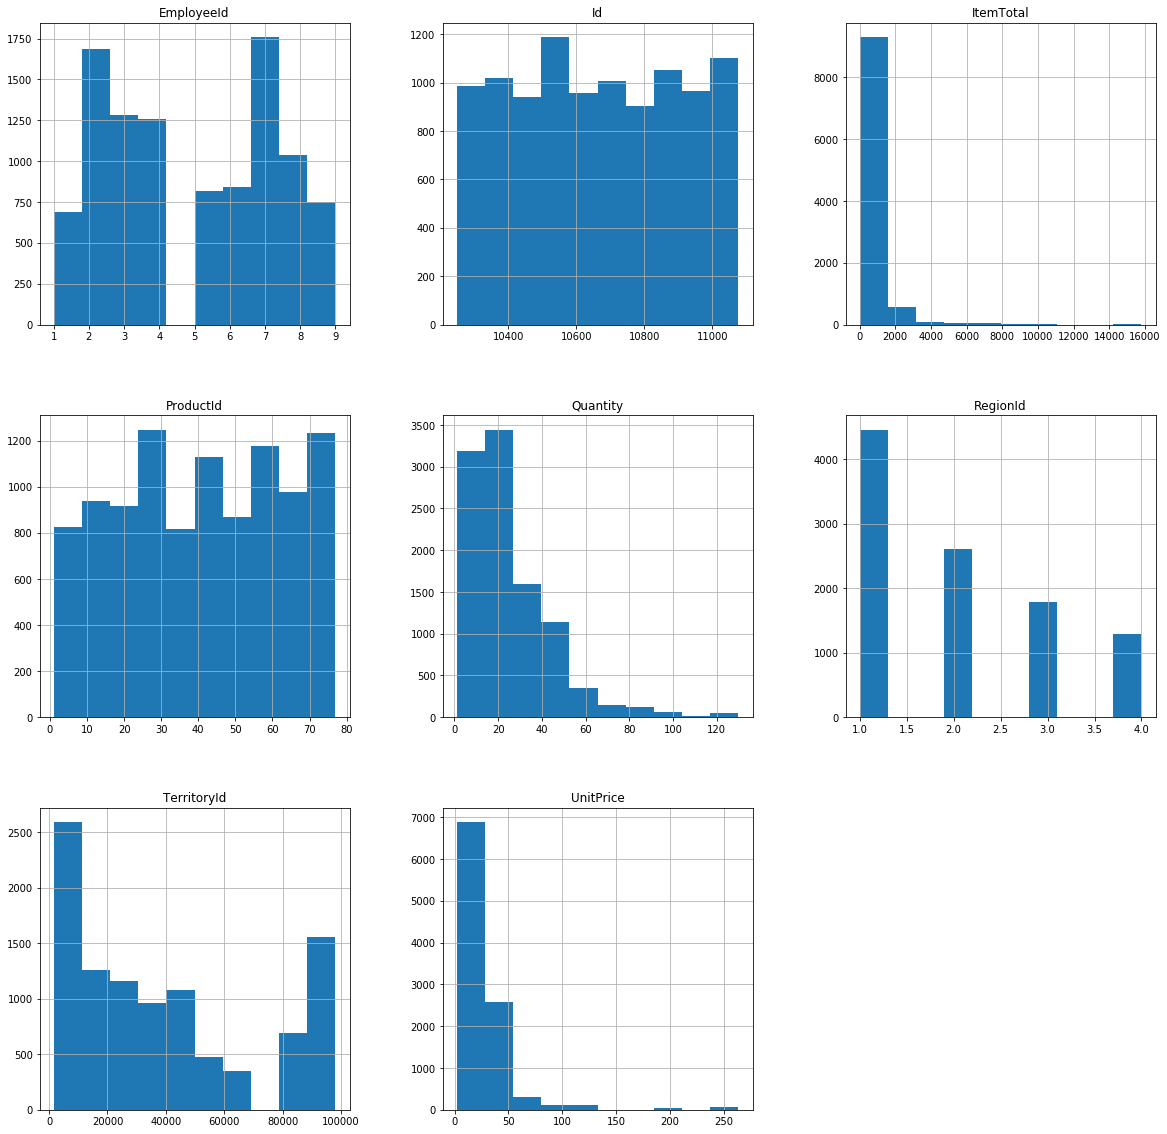

In [26]:
# visualize data
df.hist(figsize=(20,20));

### 4.2.3.2 Transform data

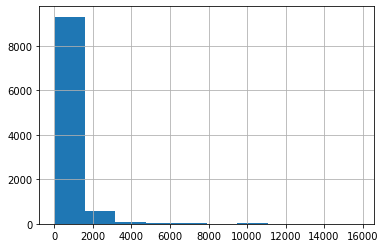

In [27]:
df['ItemTotal_log'] = df['ItemTotal'].map(lambda x: np.log(x))
df['Quantity_log'] = df['Quantity'].map(lambda x: np.log(x))
df.ItemTotal.hist()

### 4.2.3.3 Sort data / Prepare data for testing

Plan and justification of sorting data

In [28]:
# sort data
pass

Observations about sorted data

### 4.2.3.4 Develop feature

In [29]:
# create features
df['Subtotal'] = df['Quantity']*df['ItemTotal']
df['Subtotal_log'] = df['Subtotal'].map(lambda x: np.log(x))

## 4.2.4 Model Data<a id='Model Data'></a>

- 1.2.4.1 Check for data normality
- 1.2.4.2 Standard deviation and other basic statistics
- 1.2.4.3 Statistical test
- 1.2.4.4 Verification techniques

### 4.2.4.1 Check for data normality

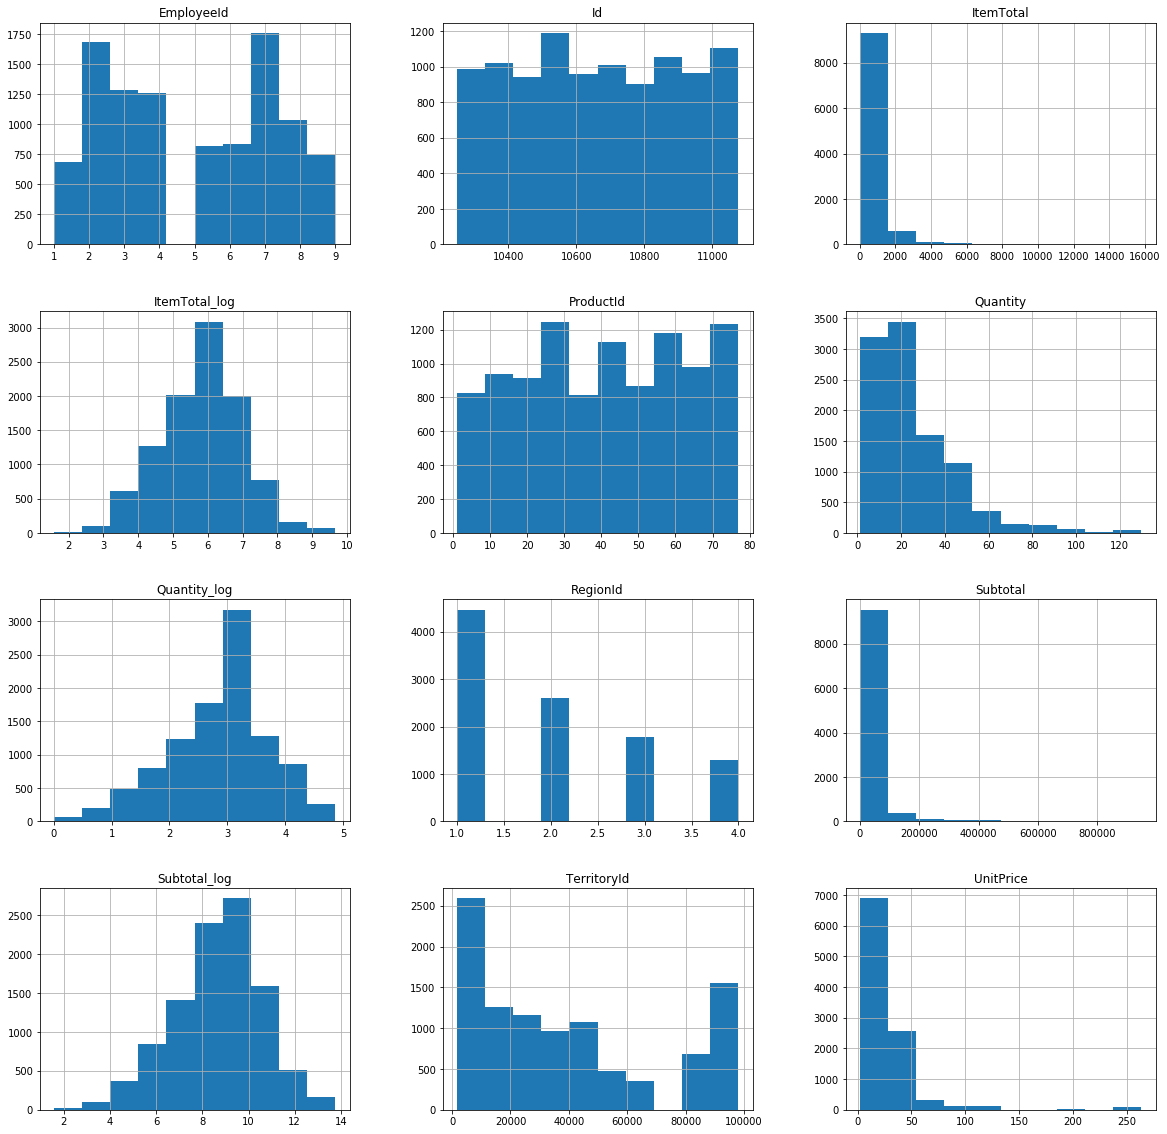

In [30]:
# visual/code for data normality
df.hist(figsize=(20,20));

### 4.2.4.2 Standard deviation and other basic statistics

In [31]:
# standard deviation for target variable
print('ItemTotal Population Measures of Variance')
print('numbers of samples: ' + str(len(df['ItemTotal_log'])))
print('population mean: ' + str(mean(df['ItemTotal_log'])))
print('population standard deviation: ' + str(std(df['ItemTotal_log'])))
print('population variance: ' + str(std(df['ItemTotal_log'])**2))
print('skew: ' + str(df['ItemTotal'].skew()))
print('Quantity Population Measures of Variance')
print('numbers of samples: ' + str(len(df['Quantity_log'])))
print('population mean: ' + str(mean(df['Quantity_log'])))
print('population standard deviation: ' + str(std(df['Quantity_log'])))
print('population variance: ' + str(std(df['Quantity_log'])**2))
print('skew: ' + str(df['Quantity'].skew()))
print('Subtotal Population Measures of Variance')
print('numbers of samples: ' + str(len(df['Subtotal_log'])))
print('population mean: ' + str(mean(df['Subtotal_log'])))
print('population standard deviation: ' + str(std(df['Subtotal_log'])))
print('population variance: ' + str(std(df['Subtotal_log'])**2))
print('skew: ' + str(df['Subtotal'].skew()))

ItemTotal Population Measures of Variance
numbers of samples: 10129
population mean: 5.822359794298912
population standard deviation: 1.165811275166423
population variance: 1.3591159293051611
skew: 6.213384822439118
Quantity Population Measures of Variance
numbers of samples: 10129
population mean: 2.874407680352321
population standard deviation: 0.8598564746203211
population variance: 0.739353156946487
skew: 1.8072311526528513
Subtotal Population Measures of Variance
numbers of samples: 10129
population mean: 8.69676747465123
population standard deviation: 1.8958711634900833
population variance: 3.5943274685532423
skew: 6.585472882294777


### 4.2.4.3 Statistical test

In [32]:
# set up variables for this particular test
alpha = 0.05
territoryId = [df[df['TerritoryId'] == x] for x in df['TerritoryId'].unique()]
len(territoryId)
x_bar_pop = df.ItemTotal_log.mean()
x_bar_sample = [x['ItemTotal_log'].mean() for x in territoryId]
sigma_pop = df.ItemTotal_log.std()
sigma_sample = [x['ItemTotal_log'].std() for x in territoryId]
n_pop = len(df.ItemTotal_log)
n_sample = [len(x['ItemTotal_log']) for x in territoryId]
mu_pop = mu_sample = 100
dof = [x-1 for x in n_sample]

In [33]:
# bonferroni correction
alpha_adj = alpha/(len(n_sample))
alpha_adj

0.0010204081632653062

In [34]:
# test
x_bar = np.array([x_bar_pop - i for i in x_bar_sample])
sigma = np.array([i**2 for i in sigma_sample])
sigma_per_sample = sigma / n_sample
t = ((x_bar) - (mu_pop-mu_sample)) / np.sqrt((sigma_pop**2/n_pop) + (sigma_per_sample))
dof_t = pd.DataFrame()
dof_t['dof'] = dof
dof_t['t'] = t

In [35]:
# result
p_value = 1-stats.t.cdf(dof_t['t'], dof_t['dof'])
p_value

array([0.68476546, 0.68476546, 0.68476546, 0.68476546, 0.68476546,
       0.68476546, 0.72187205, 0.71759218, 0.71759218, 0.00880333,
       0.72187205, 0.72187205, 0.72187205, 0.72187205, 0.72187205,
       0.72187205, 0.21202311, 0.00880333, 0.27060678, 0.27060678,
       0.27060678, 0.71619506, 0.71619506, 0.71619506, 0.71619506,
       0.68476546, 0.21202311, 0.21202311, 0.71759218, 0.71759218,
       0.71759218, 0.21202311, 0.71759218, 0.71759218, 0.85751959,
       0.85751959, 0.85751959, 0.85751959, 0.00686218, 0.00686218,
       0.85751959, 0.85751959, 0.85751959, 0.85751959, 0.85751959,
       0.85751959, 0.00686218, 0.00686218, 0.00686218])

In [36]:
# evaluation of result
for x,y in enumerate(p_value):
    if alpha > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothesis
26: Fail to 

In [37]:
# evaluation of result with bonferroni correction
for x,y in enumerate(p_value):
    if alpha_adj > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Fail to reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Fail to reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothe

In [38]:
# variables for quantity
x_bar_pop = df.Quantity_log.mean()
x_bar_sample = [x['Quantity_log'].mean() for x in territoryId]
sigma_pop = df.Quantity.std()
sigma_sample = [x['Quantity_log'].std() for x in territoryId]
n_pop = len(df.Quantity_log)
n_sample = [len(x['Quantity_log']) for x in territoryId]
mu_pop = mu_sample = 100
dof = [x-1 for x in n_sample]

In [39]:
# tests for quantity
x_bar = np.array([x_bar_pop - i for i in x_bar_sample])
sigma = np.array([i**2 for i in sigma_sample])
sigma_per_sample = sigma / n_sample
t = ((x_bar) - (mu_pop-mu_sample)) / np.sqrt((sigma_pop**2/n_pop) + (sigma_per_sample))
dof_t = pd.DataFrame()
dof_t['dof'] = dof
dof_t['t'] = t

In [40]:
# results for quantity
p_value = 1-stats.t.cdf(dof_t['t'], dof_t['dof'])
p_value

array([0.50937827, 0.50937827, 0.50937827, 0.50937827, 0.50937827,
       0.50937827, 0.70337145, 0.58190094, 0.58190094, 0.20566217,
       0.70337145, 0.70337145, 0.70337145, 0.70337145, 0.70337145,
       0.70337145, 0.44933783, 0.20566217, 0.41575908, 0.41575908,
       0.41575908, 0.54956974, 0.54956974, 0.54956974, 0.54956974,
       0.50937827, 0.44933783, 0.44933783, 0.58190094, 0.58190094,
       0.58190094, 0.44933783, 0.58190094, 0.58190094, 0.6481039 ,
       0.6481039 , 0.6481039 , 0.6481039 , 0.26786468, 0.26786468,
       0.6481039 , 0.6481039 , 0.6481039 , 0.6481039 , 0.6481039 ,
       0.6481039 , 0.26786468, 0.26786468, 0.26786468])

In [41]:
# evaluation of result for quantity
for x,y in enumerate(p_value):
    if alpha > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Fail to reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Fail to reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothe

In [42]:
# evaluation of result for quantity with bonferroni correction
for x,y in enumerate(p_value):
    if alpha_adj > y:
        print(str(x) + ': Reject the null hypothesis')
    else:
        print(str(x) + ': Fail to reject the null hypothesis')

0: Fail to reject the null hypothesis
1: Fail to reject the null hypothesis
2: Fail to reject the null hypothesis
3: Fail to reject the null hypothesis
4: Fail to reject the null hypothesis
5: Fail to reject the null hypothesis
6: Fail to reject the null hypothesis
7: Fail to reject the null hypothesis
8: Fail to reject the null hypothesis
9: Fail to reject the null hypothesis
10: Fail to reject the null hypothesis
11: Fail to reject the null hypothesis
12: Fail to reject the null hypothesis
13: Fail to reject the null hypothesis
14: Fail to reject the null hypothesis
15: Fail to reject the null hypothesis
16: Fail to reject the null hypothesis
17: Fail to reject the null hypothesis
18: Fail to reject the null hypothesis
19: Fail to reject the null hypothesis
20: Fail to reject the null hypothesis
21: Fail to reject the null hypothesis
22: Fail to reject the null hypothesis
23: Fail to reject the null hypothesis
24: Fail to reject the null hypothesis
25: Fail to reject the null hypothe

Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### 4.2.4.4 Verification techniques
#### 4.2.4.4.1 Nonparametric testing and confirmatory testing<a id='Nonparametric testing'></a>
##### Nonparametric testing

In [43]:
# non-parametric testing variables
pass

In [44]:
# non-parametric test
pass

In [45]:
# result
pass

In [46]:
# evaluation of results
pass

Oberservations based on new finding

##### Confirmatory testing

In [47]:
# confirmatory test 
pass

Oberservations based on new finding

#### 4.2.4.4.2 Effect size<a id='Effect size'></a>
Cohen's D

In [48]:
# effect size variables
pass

In [49]:
# effect size test
def cohen_d_one_samp(x, mu0):
    mu = mean(x)
    sample_std = std(x, ddof=1)
    return (mu - mu0) / sample_std
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
# effect_size = cohen_d_two_samp('', '')
# effect_size

Obeservations about effect size

#### 4.2.4.4.3 Error<a id='Error'></a>

In [50]:
# power variables
pass

In [51]:
# power test

In [52]:
# evaluation of power test

Observations about power test

### Cross validatation

In [53]:
# test train split or resampling for testing preformed above
pass

## 4.2.5 Interpret Model<a id='Interpret Model'></a>

### 4.2.5.1 Extension of acquired knowledge<a id='Extension'></a>
#### Deeper question
Even if regions are not out performing each other, are employees outperforming each other?
#### Hypothesis for deeper question

In [54]:
# deeper understanding variables
alpha = 0.05

In [55]:
# deeper understanding test for ItemTotal
item_total_anova = sm.stats.anova_lm(ols('ItemTotal_log ~ LastName', data=df).fit())

In [56]:
# deeper understanding result for ItemTotal
pvalue = item_total_anova.loc['LastName', 'PR(>F)']
pvalue

9.310479291626011e-11

In [57]:
# deeper understanding evaluation of result
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [58]:
# deeper understanding test for Quantity
quantity_anova = sm.stats.anova_lm(ols('Quantity_log ~ LastName', data=df).fit())

In [59]:
# deeper understanding result for Quantity
pvalue = quantity_anova.loc['LastName', 'PR(>F)']
pvalue

1.0608570556235375e-13

In [60]:
# deeper understanding evaluation of result
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [61]:
subtotal_anova = sm.stats.anova_lm(ols('Subtotal_log ~ LastName', data=df).fit())

In [62]:
pvalue = subtotal_anova.loc['LastName', 'PR(>F)']
pvalue

1.9255329119313361e-13

In [63]:
# deeper understanding evaluation of result
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [64]:
# nonparametric variable set up for deeper understanding ItemTotal
unique_names = df['LastName'].unique()
by_unique_names = [df[df['LastName']==i] for i in unique_names]

In [65]:
# nonparametric testing for deeper understanding ItemTotal
kruskal_stat, pvalue = stats.kruskal(by_unique_names[0]['ItemTotal_log'], by_unique_names[1]['ItemTotal_log'], by_unique_names[2]['ItemTotal_log'],
                                     by_unique_names[3]['ItemTotal_log'], by_unique_names[4]['ItemTotal_log'], by_unique_names[5]['ItemTotal_log'], 
                                     by_unique_names[6]['ItemTotal_log'], by_unique_names[7]['ItemTotal_log'], by_unique_names[8]['ItemTotal_log'])
kruskal_stat, pvalue

(49.67416893138429, 4.720282796577946e-08)

In [66]:
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [67]:
# nonparametric testing for deeper understanding Quantity
kruskal_stat, pvalue = stats.kruskal(by_unique_names[0]['Quantity_log'], by_unique_names[1]['Quantity_log'], by_unique_names[2]['Quantity_log'],
                                     by_unique_names[3]['Quantity_log'], by_unique_names[4]['Quantity_log'], by_unique_names[5]['Quantity_log'], 
                                     by_unique_names[6]['Quantity_log'], by_unique_names[7]['Quantity_log'], by_unique_names[8]['Quantity_log'])
kruskal_stat, pvalue

(67.55255875280854, 1.5064090592328184e-11)

In [68]:
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [69]:
kruskal_stat, pvalue = stats.kruskal(by_unique_names[0]['Subtotal_log'], by_unique_names[1]['Subtotal_log'], by_unique_names[2]['Subtotal_log'],
                                     by_unique_names[3]['Subtotal_log'], by_unique_names[4]['Subtotal_log'], by_unique_names[5]['Subtotal_log'], 
                                     by_unique_names[6]['Subtotal_log'], by_unique_names[7]['Subtotal_log'], by_unique_names[8]['Subtotal_log'])
kruskal_stat, pvalue

(59.287341094477235, 6.429895411921454e-10)

In [70]:
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [71]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['ItemTotal_log'], df['LastName'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Buchanan,Callahan,-0.1117,0.5029,-0.2802,0.0568,False
Buchanan,Davolio,-0.2224,0.0067,-0.4088,-0.036,True
Buchanan,Dodsworth,0.0101,0.9,-0.1722,0.1925,False
Buchanan,Fuller,-0.0197,0.9,-0.1733,0.1339,False
Buchanan,King,0.0389,0.9,-0.1137,0.1914,False
Buchanan,Leverling,-0.022,0.9,-0.1833,0.1393,False
Buchanan,Peacock,-0.094,0.6577,-0.2559,0.0679,False
Buchanan,Suyama,-0.265,0.001,-0.4422,-0.0879,True
Callahan,Davolio,-0.1107,0.5741,-0.2878,0.0664,False
Callahan,Dodsworth,0.1218,0.4175,-0.051,0.2947,False


C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


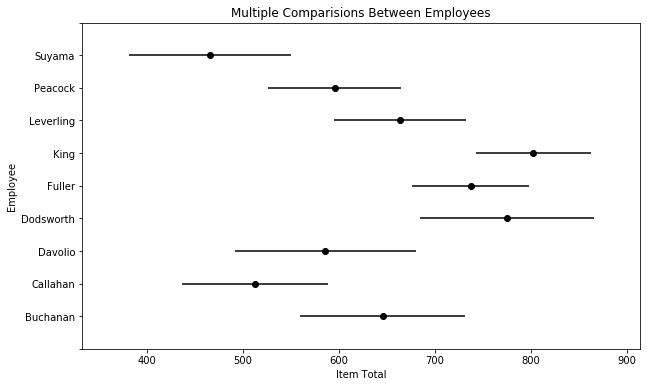

In [72]:
# create figure
fig07 = plt.figure(figsize=(5,4))
ax = fig07.add_subplot(111)

# run tukeys
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['ItemTotal'], df['LastName'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Employees')
ax.axes.set_ylabel('Employee')
ax.axes.set_xlabel('Item Total');

In [73]:
tukey_results = pairwise_tukeyhsd(df['Quantity_log'], df['LastName'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Buchanan,Callahan,-0.1352,0.021,-0.2594,-0.011,True
Buchanan,Davolio,-0.2747,0.001,-0.4121,-0.1373,True
Buchanan,Dodsworth,-0.0662,0.8238,-0.2006,0.0682,False
Buchanan,Fuller,-0.1051,0.0933,-0.2183,0.0081,False
Buchanan,King,-0.0323,0.9,-0.1447,0.0802,False
Buchanan,Leverling,-0.0851,0.394,-0.204,0.0338,False
Buchanan,Peacock,-0.1519,0.0026,-0.2712,-0.0326,True
Buchanan,Suyama,-0.2359,0.001,-0.3665,-0.1054,True
Callahan,Davolio,-0.1395,0.0257,-0.2701,-0.009,True
Callahan,Dodsworth,0.069,0.7308,-0.0584,0.1964,False


C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


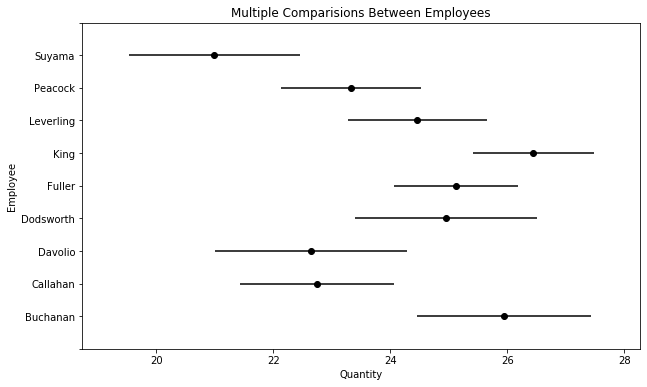

In [74]:
# create figure
fig08 = plt.figure(figsize=(5,4))
ax = fig08.add_subplot(111)

# run tukeys
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['Quantity'], df['LastName'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Employees')
ax.axes.set_ylabel('Employee')
ax.axes.set_xlabel('Quantity');

In [75]:
tukey_results = pairwise_tukeyhsd(df['Subtotal_log'], df['LastName'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Buchanan,Callahan,-0.2469,0.1166,-0.5207,0.027,False
Buchanan,Davolio,-0.4971,0.001,-0.8,-0.1942,True
Buchanan,Dodsworth,-0.056,0.9,-0.3524,0.2403,False
Buchanan,Fuller,-0.1248,0.8095,-0.3745,0.1248,False
Buchanan,King,0.0066,0.9,-0.2414,0.2545,False
Buchanan,Leverling,-0.1071,0.9,-0.3692,0.1551,False
Buchanan,Peacock,-0.2459,0.0886,-0.509,0.0172,False
Buchanan,Suyama,-0.5009,0.001,-0.7888,-0.2131,True
Callahan,Davolio,-0.2502,0.1487,-0.538,0.0376,False
Callahan,Dodsworth,0.1908,0.4702,-0.0901,0.4718,False


C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


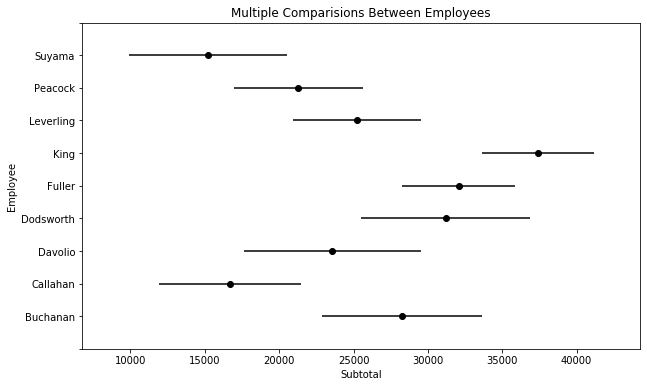

In [76]:
# create figure
fig08 = plt.figure(figsize=(5,4))
ax = fig08.add_subplot(111)

# run tukeys
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df['Subtotal'], df['LastName'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Employees')
ax.axes.set_ylabel('Employee')
ax.axes.set_xlabel('Subtotal');

Observations based off of deeper understanding test

# 4.3 Results<a id='Results'></a>

Conclusions about question overall commentary on hypothesis

# 4.4 Conclusions<a id='Conclusions'></a>

- 4.4.1 Actionable Items and Insights
- 4.4.2 Additional Visuals

## 4.4.1 Actionable Items and Insights<a id='Actionable Items and Insights'></a>

## 4.4.2 Additional Visuals

In [77]:
employee_work = df.groupby(['LastName', 'Id', 'ProductId']).mean()
employee_work

TerritoryId  RegionId  EmployeeId  ItemTotal  \
LastName Id    ProductId                                                 
Buchanan 10248 11              9422.0         1           5      168.0   
               42              9422.0         1           5       98.0   
               72              9422.0         1           5      174.0   
         10254 24              9422.0         1           5       54.0   
               55              9422.0         1           5      403.2   
...                               ...       ...         ...        ...   
Suyama   11031 24             92885.0         2           6       94.5   
               64             92885.0         2           6      665.0   
               71             92885.0         2           6      344.0   
         11045 33             92885.0         2           6       37.5   
               51             92885.0         2           6     1272.0   

                          UnitPrice  Quantity  ItemTotal_log  Quantity_log  \
LastName Id    ProductId                                                     
Buchanan 10248 11             14.00        12       5.123964      2.484907   
               42              9.80        10       4.584967      2.302585   
               72             34.80         5       5.159055      1.609438   
         10254 24              3.60        15       3.988984      2.708050   
               55             19.20        21       5.999433      3.044522   
...                             ...       ...            ...           ...   
Suyama   11031 24              4.50        21       4.548600      3.044522   
               64             33.25        20       6.499787      2.995732   
               71             21.50        16       5.840642      2.772589   
         11045 33              2.50        15       3.624341      2.708050   
               51             53.00        24       7.148346      3.178054   

                          Subtotal  Subtotal_log  
LastName Id    ProductId                          
Buchanan 10248 11           2016.0      7.608871  
               42            980.0      6.887553  
               72            870.0      6.768493  
         10254 24            810.0      6.697034  
               55           8467.2      9.043955  
...                            ...           ...  
Suyama   11031 24           1984.5      7.593122  
               64          13300.0      9.495519  
               71           5504.0      8.613230  
         11045 33            562.5      6.332391  
               51          30528.0     10.326400  

[2155 rows x 10 columns]

In [78]:
employees = df['LastName'].unique()
employees

array(['Fuller', 'Buchanan', 'Dodsworth', 'Davolio', 'Callahan',
       'Peacock', 'Leverling', 'King', 'Suyama'], dtype=object)

### Tools for use of discovered information

In [79]:
# function or equation used to test developed theories
pass

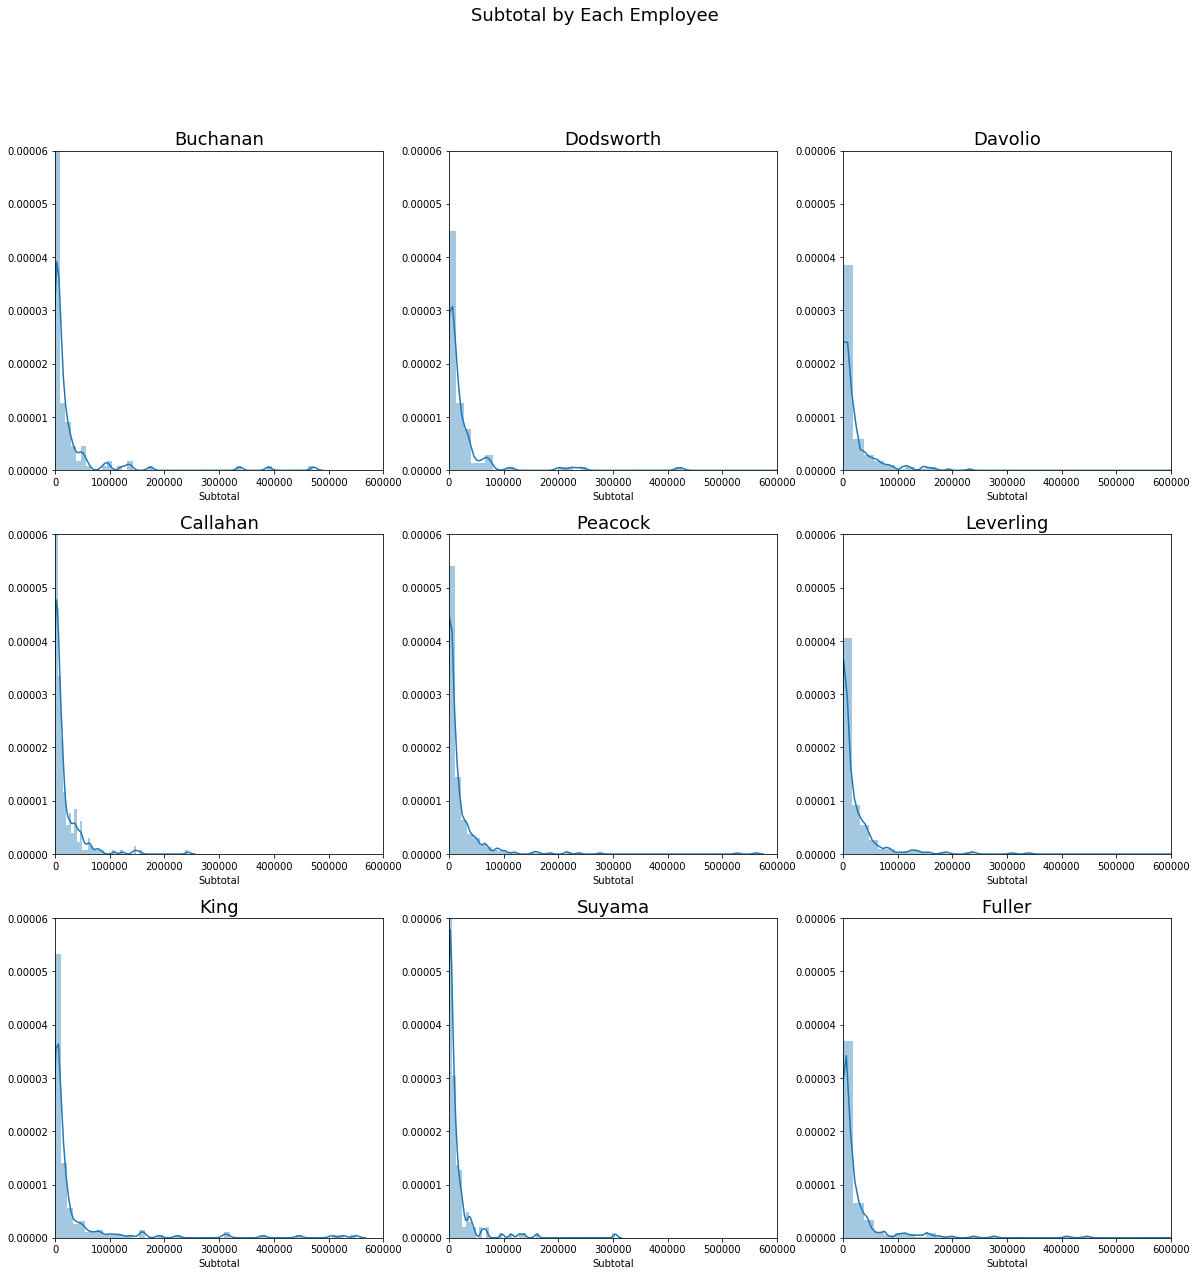

In [86]:
x = [employee_work.loc[idx[i]]['Subtotal'] for i in employees]
fig05, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for n in range(0, len(employees)):
    row = (n-1)//3
    col = n%3-1
    ax = axes[row][col]
    sns.distplot(x[n], ax=ax).set_xlim(left=0, right=600000)
    ax.set_ylim(ymax=0.00006)
    ax.set_title('{}'.format(employees[n]), fontsize=18)
fig05.suptitle('Subtotal by Each Employee', fontsize=18);

# 4.5 Future Work<a id='Future Work'></a>

What products is King selling effectively?
Set sales goals that focus on higher quantities of higher priced products.

# 4.6 References<a id='References'></a>

Measure skewness https://towardsdatascience.com/understanding-measures-of-variance-with-python-f57d59617a0b
Lat/Long: https://www.latlong.net/